In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import random
import os
import math

#use GPU running
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
#generate mobility data for input with array
data1 = np.load('5min_1node_data.npy')
data100 = np.load('5min_100node_data_id.npy')

print(len(data1))
print(len(data100))
print(data1[0])
print(data100[0])

16800
28000
[5209.9303 9194.304 ]
[5242.8832 9167.2133]


In [3]:
data1_len = len(data1)
data100_len = len(data100)

x = []
y = []
for i in range(0, data1_len-1500):
  x.append([data100[j] for j in range(i, i+1500, 100)])
  y.append(data100[i+1500])
print(len(x))
print(len(y))

16785
16785


In [4]:
x = torch.tensor(x, dtype= torch.float32)
y = torch.tensor(y, dtype = torch.float32)
print(x[0])
print(y[0])
print(x.size())
print(y.size())

tensor([[5242.8833, 9167.2129],
        [1109.7424, 4257.2510],
        [2526.0247, 7410.4321],
        [ 782.7172, 4910.9370],
        [5489.7988, 8328.6104],
        [6828.9370, 9866.6260],
        [3132.4587, 6898.1401],
        [1254.8069, 9424.6748],
        [5901.8154, 6941.8774],
        [6862.2944, 8272.2090],
        [6903.1909, 9886.4141],
        [5690.6948, 1495.7787],
        [6610.3154, 2652.8843],
        [5495.1509, 7365.6118],
        [ 242.5745, 6778.0742]])
tensor([4179.0723, 5599.8540])
torch.Size([16785, 15, 2])
torch.Size([16785, 2])


In [5]:
#initialization
batch_size = 15
#num_epochs = 10
#input_size = 108
#hidden_size = 216
#layer_num = 3

#input data to dataset
class myselfDataset(Dataset):
  def __init__(self, x, y):
    self.x  = x
    self.y  = y
    self.len = len(x)
  def __getitem__(self,index):
    return self.x[index], self.y[index]
  def __len__(self):
    return self.len

#random distribution with train and test set
def get_dataloader(batch_size):
  dataset = myselfDataset(x,y)
  train_len = int(0.9 * len(dataset))
  length = [train_len, len(dataset)-train_len]
  trainset, validset = random_split(dataset,length)
  #train_x = x[:train_len]
  #train_y = y[:train_len]
  #valid_x = x[train_len:]
  #valid_y = y[train_len:]
  #trainset = myselfDataset(train_x, train_y)
  #validset = myselfDataset(valid_x, valid_y)
  train_loader = DataLoader(dataset=trainset, batch_size=batch_size, shuffle=True)
  valid_loader = DataLoader(dataset=validset, batch_size=batch_size, shuffle=True)
  return train_loader, valid_loader

#data_length
length = len(x)
print(length)

dataset = myselfDataset(x,y)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
#train_loader, valid_loader = get_dataloader(batch_size)
#print(train_loader)
#print(valid_loader)

16785


In [6]:
import torch.optim.lr_scheduler as lr_scheduler
from torch.autograd import Variable

#initialization
batch_size = 15
num_epochs = 1500
input_dim = 3
hidden_dim = 3
layer_num = 3


#GRU model
class GRU(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_num):
        super(GRU, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_num = layer_num
        
        self.gru = nn.GRU(input_dim, hidden_dim, layer_num, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 3)
        self.relu = nn.ReLU()

    #forward
    def forward(self, x):
        h0 = Variable(torch.zeros(self.layer_num, x.size(0), self.hidden_dim)).requires_grad_().to(device)
        out, (hn) = self.gru(x, (h0.detach()))
        out = self.fc(self.relu(out[:,-1,:]))
        #out = hn.view(-1, self.hidden_dim)
        #out = self.fc(out)
        return out

#loss and optimizer /MSELoss()
gru = GRU(input_dim, hidden_dim, layer_num).to(device)
learning_rate = 0.05
loss = nn.MSELoss().to(device)
optimizer = optim.SGD(gru.parameters(), lr=learning_rate, momentum = 0.9)
#optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate)

#lambda1 = lambda epoch: 0.95
scheduler = lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

#training loop
FADarray = []
MADarray = []

for epoch in range(num_epochs):
      MADdist = 0
      for i, (inputs, labels) in enumerate(train_loader):
        #print(inputs)
        #inputs = inputs.reshape(batch_size, 60, input_size).to(device)
        #print(inputs.shape)

        #forward
        y_pred = gru(inputs.to(device))
        #print(y_pred)
        l = loss(y_pred, labels.to(device))

        #backward
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    
        MADdistx = 0
        for x in range(len(y_pred)):
            MADa = y_pred[x].cpu().detach().numpy()
            MADb = np.array(labels[x])
            MADdistx += np.sqrt(np.sum(np.square(MADa - MADb)))
        MADdist += MADdistx/len(y_pred)
    
        #if (i+1) % 200 == 0:
          #print(f"epoch = {epoch+1}, step = {i+1} , y's prediction = {y_pred[0].tolist()}, loss = {l.item():.4f}")
      #FADdisty = 0
      #for y in range(len(y_pred)):
          #FADa = y_pred[y].cpu().detach().numpy()
          #FADb = np.array(labels[y])
          #FADdisty += np.sqrt(np.sum(np.square(FADa - FADb)))
      #FADdist = FADdisty/len(y_pred)
      MADdist = MADdist/len(train_loader)
      print(f"epoch = {epoch+1}, Mad = {MADdist}")
      #FADarray.append(FADdist)
      MADarray.append(MADdist)
      scheduler.step()



epoch = 1, Mad = 4251.25300407421, Fad = 4469.041861979166
epoch = 2, Mad = 4223.614538113097, Fad = 3513.1936889648437
epoch = 3, Mad = 4195.7453199994015, Fad = 4378.11601155599
epoch = 4, Mad = 4257.13879394304, Fad = 3978.338899739583
epoch = 5, Mad = 4200.48706185116, Fad = 4182.792830403646
epoch = 6, Mad = 4226.075972063957, Fad = 4507.605444335937
epoch = 7, Mad = 4167.60372181047, Fad = 3732.034847005208
epoch = 8, Mad = 4253.45859933625, Fad = 4359.268481445312
epoch = 9, Mad = 4154.821864035214, Fad = 4358.64530843099
epoch = 10, Mad = 4237.042645525481, Fad = 4658.834285481771
epoch = 11, Mad = 4145.529660608266, Fad = 4657.3553466796875
epoch = 12, Mad = 4255.605875971953, Fad = 4713.67890625
epoch = 13, Mad = 4225.9324229304275, Fad = 3696.890690104167
epoch = 14, Mad = 4203.5919027320015, Fad = 4140.490983072917
epoch = 15, Mad = 4207.982401884711, Fad = 4927.101570638021
epoch = 16, Mad = 4209.993941722009, Fad = 5589.718660481771
epoch = 17, Mad = 4301.120331554618, Fa

epoch = 135, Mad = 3860.53963902928, Fad = 4182.9731038411455
epoch = 136, Mad = 3861.127191798912, Fad = 4307.229191080729
epoch = 137, Mad = 3852.836134417245, Fad = 3587.6295166015625
epoch = 138, Mad = 3854.046936751508, Fad = 3888.053499348958
epoch = 139, Mad = 3864.9673076939907, Fad = 3852.6428568522138
epoch = 140, Mad = 3855.021545897701, Fad = 3828.626806640625
epoch = 141, Mad = 3858.9335047643767, Fad = 3842.386466471354
epoch = 142, Mad = 3860.761128605989, Fad = 4154.304833984375
epoch = 143, Mad = 3850.372390492643, Fad = 4132.737418619791
epoch = 144, Mad = 3857.4553697687707, Fad = 4115.813167317709
epoch = 145, Mad = 3859.5620338475196, Fad = 4398.2767578125
epoch = 146, Mad = 3857.357396697096, Fad = 3829.27958984375
epoch = 147, Mad = 3862.7284006695436, Fad = 4066.7022216796877
epoch = 148, Mad = 3850.9790416884553, Fad = 3433.5167561848957
epoch = 149, Mad = 3858.00288334296, Fad = 4426.141959635416
epoch = 150, Mad = 3861.1622254281574, Fad = 3817.4190348307293


epoch = 266, Mad = 3828.8545617606646, Fad = 4219.303133138021
epoch = 267, Mad = 3828.282822667976, Fad = 3728.383121744792
epoch = 268, Mad = 3827.8908758204993, Fad = 3489.6702514648437
epoch = 269, Mad = 3828.849065587578, Fad = 3473.400699869792
epoch = 270, Mad = 3829.283400394734, Fad = 3623.5450073242187
epoch = 271, Mad = 3828.7910659794575, Fad = 4234.260723876953
epoch = 272, Mad = 3829.8122805243406, Fad = 3305.5150390625
epoch = 273, Mad = 3829.354729406445, Fad = 3511.6173583984373
epoch = 274, Mad = 3829.5980844488026, Fad = 4205.004768880209
epoch = 275, Mad = 3828.247815505032, Fad = 3889.45009765625
epoch = 276, Mad = 3828.5501491625014, Fad = 4149.635046386718
epoch = 277, Mad = 3827.6838438995933, Fad = 3967.9934651692706
epoch = 278, Mad = 3828.7714489893324, Fad = 3452.3274169921874
epoch = 279, Mad = 3828.332468581351, Fad = 3958.7107462565104
epoch = 280, Mad = 3830.011199110732, Fad = 3467.5213907877605
epoch = 281, Mad = 3830.166207003944, Fad = 4178.079003906

epoch = 397, Mad = 3825.680427747175, Fad = 3991.8929524739583
epoch = 398, Mad = 3826.254932622421, Fad = 3879.8910888671876
epoch = 399, Mad = 3825.5781338143656, Fad = 4394.870068359375
epoch = 400, Mad = 3825.5740480515574, Fad = 3282.5329142252604
epoch = 401, Mad = 3826.7132198693857, Fad = 3887.5384440104167
epoch = 402, Mad = 3825.7043101056506, Fad = 3291.874157714844
epoch = 403, Mad = 3825.901054446416, Fad = 3560.748811848958
epoch = 404, Mad = 3825.456708852739, Fad = 4080.513850911458
epoch = 405, Mad = 3825.7268083296804, Fad = 4151.357983398438
epoch = 406, Mad = 3825.2033715314915, Fad = 4140.772436523437
epoch = 407, Mad = 3825.2405682956696, Fad = 3579.235847981771
epoch = 408, Mad = 3825.2969744634884, Fad = 4295.282421875
epoch = 409, Mad = 3825.567418006348, Fad = 4283.977587890625
epoch = 410, Mad = 3825.792872457356, Fad = 3705.5708577473956
epoch = 411, Mad = 3825.4073291022933, Fad = 4000.79150390625
epoch = 412, Mad = 3825.160265176939, Fad = 3608.08479817708

epoch = 528, Mad = 3825.4094593746895, Fad = 3767.837927246094
epoch = 529, Mad = 3825.4290225440614, Fad = 4194.115201822917
epoch = 530, Mad = 3825.4360082149697, Fad = 3625.246346028646
epoch = 531, Mad = 3825.4140279115927, Fad = 3830.368017578125
epoch = 532, Mad = 3825.4577028476238, Fad = 3558.1630737304686
epoch = 533, Mad = 3825.437952583778, Fad = 4110.144986979167
epoch = 534, Mad = 3825.4391935337703, Fad = 3881.298543294271
epoch = 535, Mad = 3825.3891989973026, Fad = 4088.922607421875
epoch = 536, Mad = 3825.4728296665694, Fad = 3915.4126139322916
epoch = 537, Mad = 3825.445334228662, Fad = 3788.6385823567707
epoch = 538, Mad = 3825.442664246935, Fad = 3626.7885986328124
epoch = 539, Mad = 3825.4819028598154, Fad = 3906.945849609375
epoch = 540, Mad = 3825.440593429716, Fad = 3397.260319010417
epoch = 541, Mad = 3825.447586640466, Fad = 4400.615804036458
epoch = 542, Mad = 3825.454642886336, Fad = 3536.4506876627606
epoch = 543, Mad = 3825.4105848269787, Fad = 3615.207352

epoch = 659, Mad = 3825.4316879767903, Fad = 4405.991227213542
epoch = 660, Mad = 3825.423461517708, Fad = 3634.2680867513022
epoch = 661, Mad = 3825.422878083791, Fad = 3356.4881306966145
epoch = 662, Mad = 3825.4215807240003, Fad = 3789.49609375
epoch = 663, Mad = 3825.4255192406354, Fad = 3537.116650390625
epoch = 664, Mad = 3825.4258807116653, Fad = 3791.2932088216144
epoch = 665, Mad = 3825.430254272421, Fad = 3569.116748046875
epoch = 666, Mad = 3825.430084948501, Fad = 3655.26103515625
epoch = 667, Mad = 3825.4248575391857, Fad = 4029.048404947917
epoch = 668, Mad = 3825.421713168657, Fad = 2626.9134033203127
epoch = 669, Mad = 3825.4317927674488, Fad = 3647.8768961588544
epoch = 670, Mad = 3825.425825389127, Fad = 3956.132604980469
epoch = 671, Mad = 3825.422767884154, Fad = 3412.0320393880206
epoch = 672, Mad = 3825.424656757698, Fad = 4253.862577311198
epoch = 673, Mad = 3825.430590216689, Fad = 4189.046329752604
epoch = 674, Mad = 3825.4310338642745, Fad = 3578.635774739583


epoch = 790, Mad = 3825.424130237206, Fad = 3792.269010416667
epoch = 791, Mad = 3825.4245316165375, Fad = 4099.128190104167
epoch = 792, Mad = 3825.4245798283127, Fad = 3547.840124511719
epoch = 793, Mad = 3825.4243373331124, Fad = 3700.133858235677
epoch = 794, Mad = 3825.424025010196, Fad = 3929.572444661458
epoch = 795, Mad = 3825.423684976919, Fad = 4622.846305338541
epoch = 796, Mad = 3825.4239823055877, Fad = 4051.206270345052
epoch = 797, Mad = 3825.423709827343, Fad = 3840.3813232421876
epoch = 798, Mad = 3825.4240637912512, Fad = 3699.645711263021
epoch = 799, Mad = 3825.4240424680393, Fad = 3953.4915161132812
epoch = 800, Mad = 3825.4242703489845, Fad = 3825.0611368815103
epoch = 801, Mad = 3825.424014894033, Fad = 3658.67104288737
epoch = 802, Mad = 3825.4240148940344, Fad = 3640.252677408854
epoch = 803, Mad = 3825.4240281283132, Fad = 4172.357096354167
epoch = 804, Mad = 3825.4240148940303, Fad = 4016.791719563802
epoch = 805, Mad = 3825.4240291828373, Fad = 3695.79169921

epoch = 921, Mad = 3825.4240148940294, Fad = 4190.2794921875
epoch = 922, Mad = 3825.4240148940353, Fad = 4304.692952473958
epoch = 923, Mad = 3825.424014894033, Fad = 3225.8568725585938
epoch = 924, Mad = 3825.424014894031, Fad = 3616.824910481771
epoch = 925, Mad = 3825.424014894027, Fad = 4083.6622233072917
epoch = 926, Mad = 3825.4240148940344, Fad = 3554.6841796875
epoch = 927, Mad = 3825.424014894033, Fad = 3446.763301595052
epoch = 928, Mad = 3825.4240148940294, Fad = 3635.9441528320312
epoch = 929, Mad = 3825.424014894033, Fad = 4254.075211588542
epoch = 930, Mad = 3825.4240148940294, Fad = 3742.582958984375
epoch = 931, Mad = 3825.4240148940344, Fad = 2829.2953287760415
epoch = 932, Mad = 3825.424014894026, Fad = 4208.157747395833
epoch = 933, Mad = 3825.424014894027, Fad = 3473.7459716796875
epoch = 934, Mad = 3825.424014894029, Fad = 3397.160477701823
epoch = 935, Mad = 3825.4240148940353, Fad = 4068.1744466145833
epoch = 936, Mad = 3825.4240148940403, Fad = 3848.68068440755

epoch = 1052, Mad = 3825.424014894034, Fad = 3246.9910237630206
epoch = 1053, Mad = 3825.424014894031, Fad = 4754.9734375
epoch = 1054, Mad = 3825.424014894029, Fad = 4313.999357096354
epoch = 1055, Mad = 3825.424014894037, Fad = 3454.5933430989585
epoch = 1056, Mad = 3825.424014894039, Fad = 3964.619677734375
epoch = 1057, Mad = 3825.4240148940353, Fad = 3758.5894124348956
epoch = 1058, Mad = 3825.424014894034, Fad = 4247.966031901042
epoch = 1059, Mad = 3825.424014894032, Fad = 3559.1479370117186
epoch = 1060, Mad = 3825.4240148940303, Fad = 3525.0503540039062
epoch = 1061, Mad = 3825.4240148940353, Fad = 3867.4264322916665
epoch = 1062, Mad = 3825.424014894034, Fad = 3368.768701171875
epoch = 1063, Mad = 3825.4240148940294, Fad = 3865.9727091471354
epoch = 1064, Mad = 3825.4240148940344, Fad = 4280.841227213542
epoch = 1065, Mad = 3825.4240148940344, Fad = 3938.7107666015627
epoch = 1066, Mad = 3825.424014894033, Fad = 3878.1519368489585
epoch = 1067, Mad = 3825.424014894034, Fad = 

epoch = 1181, Mad = 3825.4240148940344, Fad = 3791.2689860026044
epoch = 1182, Mad = 3825.424014894033, Fad = 3731.010107421875
epoch = 1183, Mad = 3825.424014894033, Fad = 3499.124332682292
epoch = 1184, Mad = 3825.424014894028, Fad = 3767.5691731770835
epoch = 1185, Mad = 3825.424014894033, Fad = 3934.412906901042
epoch = 1186, Mad = 3825.4240148940353, Fad = 3980.2545654296873
epoch = 1187, Mad = 3825.4240148940344, Fad = 3543.582560221354
epoch = 1188, Mad = 3825.424014894034, Fad = 4255.6326171875
epoch = 1189, Mad = 3825.424014894034, Fad = 3986.2524617513022
epoch = 1190, Mad = 3825.424014894041, Fad = 4021.4725260416667
epoch = 1191, Mad = 3825.424014894029, Fad = 4065.2103759765623
epoch = 1192, Mad = 3825.424014894037, Fad = 3483.065625
epoch = 1193, Mad = 3825.4240148940344, Fad = 4303.809130859375
epoch = 1194, Mad = 3825.424014894031, Fad = 2875.2903971354167
epoch = 1195, Mad = 3825.424014894038, Fad = 3772.6199869791667
epoch = 1196, Mad = 3825.424014894034, Fad = 3405.4

epoch = 1310, Mad = 3825.424014894032, Fad = 4217.876692708333
epoch = 1311, Mad = 3825.424014894026, Fad = 4073.3587320963543
epoch = 1312, Mad = 3825.4240148940303, Fad = 3946.004671223958
epoch = 1313, Mad = 3825.4240148940294, Fad = 3925.5467203776043
epoch = 1314, Mad = 3825.4240148940353, Fad = 3814.355013020833
epoch = 1315, Mad = 3825.424014894031, Fad = 3627.584265136719
epoch = 1316, Mad = 3825.424014894034, Fad = 3825.85634765625
epoch = 1317, Mad = 3825.4240148940303, Fad = 3529.6013061523436
epoch = 1318, Mad = 3825.424014894033, Fad = 4099.638264973958
epoch = 1319, Mad = 3825.4240148940353, Fad = 3549.0928344726562
epoch = 1320, Mad = 3825.4240148940353, Fad = 3623.086962890625
epoch = 1321, Mad = 3825.424014894038, Fad = 4165.018465169271
epoch = 1322, Mad = 3825.4240148940344, Fad = 4063.8717122395833
epoch = 1323, Mad = 3825.424014894032, Fad = 3257.651603190104
epoch = 1324, Mad = 3825.424014894038, Fad = 4191.91630859375
epoch = 1325, Mad = 3825.424014894027, Fad = 

epoch = 1440, Mad = 3825.424014894032, Fad = 4025.394287109375
epoch = 1441, Mad = 3825.424014894032, Fad = 3736.8405151367188
epoch = 1442, Mad = 3825.424014894026, Fad = 4105.738427734375
epoch = 1443, Mad = 3825.424014894029, Fad = 3796.110392252604
epoch = 1444, Mad = 3825.424014894039, Fad = 3658.3585123697917
epoch = 1445, Mad = 3825.424014894033, Fad = 4206.957039388021
epoch = 1446, Mad = 3825.4240148940344, Fad = 2970.769140625
epoch = 1447, Mad = 3825.424014894029, Fad = 3711.9353841145835
epoch = 1448, Mad = 3825.4240148940353, Fad = 3947.3014892578126
epoch = 1449, Mad = 3825.424014894036, Fad = 3765.487137858073
epoch = 1450, Mad = 3825.424014894032, Fad = 3463.197762044271
epoch = 1451, Mad = 3825.424014894038, Fad = 3844.2739095052084
epoch = 1452, Mad = 3825.424014894028, Fad = 4229.542268880208
epoch = 1453, Mad = 3825.424014894032, Fad = 3542.173376464844
epoch = 1454, Mad = 3825.424014894032, Fad = 3475.8064982096353
epoch = 1455, Mad = 3825.4240148940303, Fad = 3483

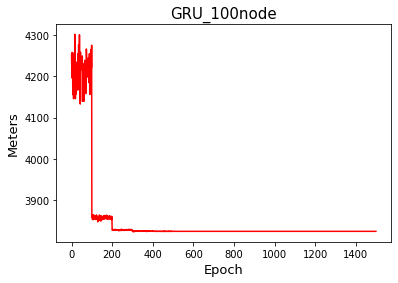

In [9]:
import matplotlib.pyplot as plt 
epocharray = []
epocharray = [i for i in range(num_epochs)]

#plt.plot(epocharray,FADarray, color="blue")
plt.plot(epocharray,MADarray, color="red")
plt.title("GRU_100node",fontsize=15)
plt.xlabel("Epoch",fontsize=13)
plt.ylabel("Meters",fontsize=13)
plt.savefig('GRU_100node.png')
plt.show()